In [3]:
import pandas as pd
import numpy as np
import requests
import camelot

C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  camelot.plot(s[0], kind='contour').show()
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\Users\RylaElli\AppData\L

,Well Name,Year,Month,Oil (m^3),Gas(10^3m^3,Water(m3)
3,HIB-B-016-001,2000,1,"122,969.80","24,992.10",0.00
4,HIB-B-016-001,2000,2,"106,695.10","19,896.60",0.00
5,HIB-B-016-001,2000,3,"122,757.00","24,610.90",0.00
6,HIB-B-016-001,2000,4,"147,583.50","31,043.10",0.00
7,HIB-B-016-001,2000,5,"195,111.80","41,449.30",0.00
...,...,...,...,...,...,...
13,HIB-B-016-019Z,2000,9,"29,647.10","2,993.60",0.00
14,HIB-B-016-019Z,2000,10,"20,794.60","1,916.20",0.00
15,HIB-B-016-019Z,2000,11,"18,831.80","1,775.00",0.00
16,HIB-B-016-019Z,2000,12,"24,978.90","2,307.70",0.00


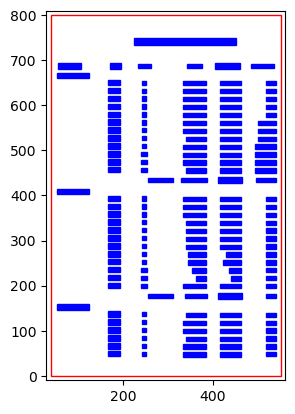

In [4]:
table_areas = ['40,800,550,0']
s = camelot.read_pdf('https://www.cnlopb.ca/wp-content/uploads/hibstats/hib_oil_2000.pdf', pages='all', flavor='stream', table_areas=table_areas)
camelot.plot(s[0], kind='contour').show()

def process_old(camelot):
    df_concat = pd.DataFrame()
    last_well_name = None
    for table in range(len(camelot)):
        df = pd.DataFrame(camelot[table].df)
        df = df.drop(3, axis=1)
        df.columns = ['Well Name', 'Year', 'Month', 'Oil (m^3)', 'Gas(10^3m^3', 'Water(m3)']
        df = df[~(df['Well Name'] == 'Well Name')]
        if last_well_name != None:
            df.iloc[0,0] = last_well_name
        df = df.replace('', np.nan)
        df['Well Name'] = df['Well Name'].fillna(method='ffill')
        df = df.dropna()
        last_well_name = df['Well Name'].values[-1]
        df_concat = pd.concat([df, df_concat])
    df['Well Name'] = df['Well Name'].str.strip()

    df_concat['Month'] = pd.to_numeric(df_concat['Month'])
    df_concat = df_concat.sort_values(['Well Name', 'Month'])

    return df_concat

process_old(s)

In [5]:
def process(camelot):
    for table in range(len(camelot)):
        df = pd.DataFrame(camelot[table].df)
        df.columns = ['Year', 'Month', 'Oil (m³)', 'Gas (10³m³)', 'Water (m3)']
        df.reset_index(drop=True, inplace=True)
        df[['Well Name', 'Year']] = df[['Well Name', 'Year']].replace('', np.nan)
        df[['Well Name', 'Year']] = df[['Well Name', 'Year']].fillna(method='ffill')
        df = df[~(df['Well Name'] == 'Yearly Total:')]
    
    return df

In [6]:
base = "https://www.cnlopb.ca/wp-content/uploads/"
project = ['hib', 'heb', 'na', 'tn', 'wr']
years = [str(year) for year in range(1997, 2025)] # Note: Style changes from 2015 to 2016
pdf = "{}stats/{}_oil_{}.pdf"
tables = pd.DataFrame()

for i in project:
    for year in years:
        try:
            print(i, year)

            if int(year) <= 2015:
                table_areas = ['40,800,550,0']
                c = camelot.read_pdf(base + pdf.format(i,i,year), pages='all', flavor='stream', table_areas=table_areas)
                df = process_old(c)
                tables = pd.concat([tables, df])
            else:
                c = camelot.read_pdf(base + pdf.format(i,i,year), pages='all', flavor='lattice')
                df = process(c)
                tables = pd.concat([tables, df])
        except Exception as e:
            print('Error: ' + str(e))

tables['Date'] = tables['Year'] + '-' + tables['Month'] + '-01'
tables['Date'] = pd.to_datetime(tables['Date'], errors='coerce')
tables = tables.drop(columns=['Year', 'Month'])
tables['Oil (m³)'] = tables['Oil (m³)'].str.replace(',', '')
tables['Gas (10³m³)'] = tables['Gas (10³m³)'].str.replace(',', '')
tables['Water (m³)'] = tables['Water (m³)'].str.replace(',', '')
tables['Gas (10³m³)'] = tables['Gas (10³m³)'].str.replace(',', '')
tables['Oil (m³)'] = pd.to_numeric(tables['Oil (m³)'], errors='coerce')
tables['Gas (10³m³)'] = pd.to_numeric(tables['Gas (10³m³)'], errors='coerce')
tables['Water (m³)'] = pd.to_numeric(tables['Water (m³)'], errors='coerce')
tables['Oil (bbl)'] = tables['Oil (m³)'] * 6.2898
tables['Gas (cf)'] = (tables['Gas (10³m³)'] / 1000) * 35.3147
tables = tables.dropna()

10.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
tn 2005
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\Users\RylaElli\AppData\Local\Temp\ipykernel_15496\638066010.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Well Name'] = df['Well Name'].fillna(method='ffill')
C:\U

TypeError: can only concatenate str (not "int") to str

In [90]:
for name in tables['Well Name'].unique():
    well = tables[tables['Well Name'] == name]
    well = well.reset_index(drop=True)
    well['Production Month'] = well.index
    tables.loc[tables['Well Name'] == name, 'Production Month'] = well['Production Month']

In [7]:
tables

,Well Name,Year,Month,Oil (m^3),Gas(10^3m^3,Water(m3)
2,HIB-B-016-001,1997,11,"37,736.80","8,021.90",0.00
3,HIB-B-016-001,1997,12,"126,282.90","27,341.80",0.00
2,HIB-B-016-001,1998,1,"163,965.00","27,598.60",0.00
3,HIB-B-016-001,1998,2,"148,909.40","31,530.40",0.00
4,HIB-B-016-001,1998,3,"50,191.70","11,585.60",0.00
...,...,...,...,...,...,...
37,WRS-E-018-008,2010,8,"20,311.50","3,093.90","32,974.90"
2,WRS-E-018-008,2010,9,"22,164.90","3,000.10","30,672.20"
3,WRS-E-018-008,2010,10,"10,840.60","1,472.00","14,717.90"
4,WRS-E-018-008,2010,11,"21,026.20","2,824.20","30,604.00"
